In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import sys
import timeit
from pynx.ptycho.bragg import *
from pynx.wavefront import Wavefront, ImshowRGBA, PropagateNearField
from pynx.utils.math import smaller_primes
from silx.io.specfile import SpecFile
import fabio
from scipy.ndimage.measurements import center_of_mass
default_processing_unit.use_gpu()

gpyfft version: 0.7.0
Computing FFT speed for available CUDA GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                         GeForce GTX TITAN X: 12287Mb , 304.80 Gflop/s
Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                           GeForce GTX TITAN X [NVIDIA CUDA]: 12287Mb [max alloc.: 3072Mb], 249.71 Gflop/s
Using CUDA GPU: GeForce GTX TITAN X


True

In [2]:
# Bragg ptycho parameters
specfile= "data/align.spec"
scan0, scan1 = 21, 139  # scan range
image_prefix= "data/detector/data_mpx4_%05d.edf.gz"

In [3]:
# 
# Read spec scans
vs = {}
first = True
for i in range(scan0,scan1+1):
    s = SpecFile(specfile)['%d.1' % (i)]
    h = s.scan_header_dict
    if first:
        nrj = float(h['UMONO'].split('mononrj=')[1].split('ke')[0])
        wavelength = 12.384 / nrj * 1e-10
        print("Reading nrj from spec data: nrj=%6.3fkeV, wavelength=%6.3fA" % (nrj, wavelength*1e10))
        #detector_distance = float(h['UDETCALIB'].split('stance_CC=')[1].split(',')[0])
        detector_distance = 1.401096
        print("Detector distance: %6.3fm"% detector_distance)
        first=False
    vs[i]={'eta':np.deg2rad(s.motor_position_by_name('eta')),
           'phi':np.deg2rad(s.motor_position_by_name('phi')), 
           'del':np.deg2rad(s.motor_position_by_name('del')),
           'nu':np.deg2rad(s.motor_position_by_name('nu')),
           'mpx4inr':s.data_column_by_name('mpx4inr').astype(np.int),
           'pix': s.data_column_by_name('pix') ,'piz': s.data_column_by_name('piz'),
           'mpx4int': s.data_column_by_name('mpx4int')
          }

Reading nrj from spec data: nrj= 9.000keV, wavelength= 1.376A
Detector distance:  1.401m


Angular range= 0.761°, step=0.0065°, 119 spirals
75


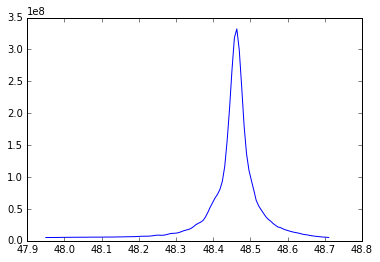

In [4]:
# Angular scan parameters
npsi = len(vs)
vphi = np.array([ vs[i]['phi'] for i in range(scan0,scan1)])
iobssum = np.array([ vs[i]['mpx4int'].sum() for i in range(scan0,scan1)])
phistep = (vphi[-1] - vphi[0])/(len(vphi)-1)
print("Angular range= %5.3f°, step=%6.4f°, %d spirals"%(np.rad2deg(vphi[-1] - vphi[0]), np.rad2deg(phistep), npsi))
# Intensity vs angle
%matplotlib inline
plt.plot(np.rad2deg(vphi), iobssum)
ipsi0 = int(round(center_of_mass(np.array(iobssum))[0]))
print(ipsi0)

In [5]:
# Load all images for the central spiralscan
iscan0 = scan0 + ipsi0
print('iscan0=',iscan0)
iobsc = None
ii = 0
t0= timeit.default_timer()
for i in vs[iscan0]['mpx4inr']:
    if (i - vs[iscan0]['mpx4inr'][0]) % 20 == 0:
        sys.stdout.write('%d ' % (i - vs[iscan0]['mpx4inr'][0]))
        sys.stdout.flush()
    frame = np.fliplr(fabio.open(image_prefix % i).data)
    if iobsc is None:
        iobsc = np.empty((len(vs[iscan0]['mpx4inr']), frame.shape[0], frame.shape[1]), dtype=frame.dtype)
    iobsc[ii] = frame
    ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobsc.size / 1e6 / dt))

iscan0= 96
0 20 40 60 80 100 120 

Time to read all frames:  1.5s [23.19 Mpixel/s]


Center of mass: y0=234.6, x0=388.1


/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


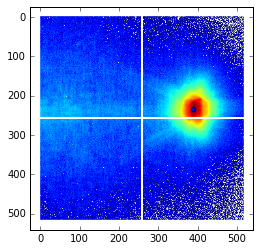

In [6]:
# Find center of diffraction
plt.imshow(np.log10(iobsc.sum(axis=0)))
y0, x0 = center_of_mass(iobsc.sum(axis=0))
print("Center of mass: y0=%5.1f, x0=%5.1f"%(y0,x0))
ny0, nx0 = iobsc.shape[-2:]
ix0 = int(round(x0))
iy0 = int(round(y0))

if False:
    # Manually correct position
    ix0 -= 35
    iy0 -=5
plt.scatter([ix0],[iy0])  # To check visually

In [7]:
# Size of crop array
nx = 2 * min(ix0, nx0 - ix0)
ny = 2 * min(iy0, ny0 - iy0)
npsi0 = scan1-scan0  # +1 ?
npsi = 2 * min(ipsi0, npsi0 - ipsi0)
# crop to max fft size
npsi, ny, nx = smaller_primes((npsi, ny, nx), maxprime=default_processing_unit.max_prime_fft, required_dividers=(2,))
vphi = vphi[:npsi]

(86, 470, 256) <class 'tuple'>


(129,)


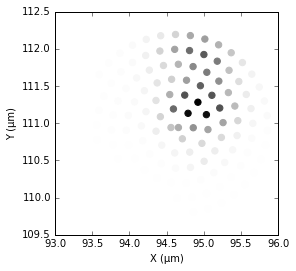

In [8]:
# Select area - too many frames !
#plt.plot(vs[ic]['pix'],iobsc.sum(axis=(1,2)))
v = iobsc.sum(axis=(1,2))
xp = vs[iscan0]['pix']
yp = vs[iscan0]['piz']
zp = 0 * xp
%matplotlib inline
ax=plt.scatter(xp,yp,40,v/v.max(), vmin=0,vmax=1, cmap=plt.cm.Greys, edgecolors='face')
plt.gca().set_aspect(1)
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
print(zp.shape)

In [9]:
vpos = np.nonzero((xp>94.5)*(xp<95.3)*(yp>111)*(yp<111.7))[0]
npos = len(vpos)
print("Number of scan positions selected: %d"%(npos))

Number of scan positions selected: 14


In [10]:
# Now load all the data
iobs = np.empty((npos,npsi,ny,nx),dtype=np.float32)
ii = 0
t0= timeit.default_timer()
print("%d frames to read:"%(npos*npsi))
for j in range(len(vpos)):
    ipos = vpos[j]
    for ipsi in range(npsi):
        i = vs[iscan0-npsi//2+ipsi]['mpx4inr'][ipos]
        if ii % 20 == 0:
            sys.stdout.write('%d ' % (ii))
            sys.stdout.flush()
        frame = np.fliplr(fabio.open(image_prefix % i).data)
        iobs[j, ipsi] = frame[iy0-ny//2:iy0+ny//2,ix0-nx//2:ix0+nx//2]
        ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobs.size / 1e6 / dt))

1176 frames to read:
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 

Time to read all frames: 15.2s [ 8.92 Mpixel/s]


/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


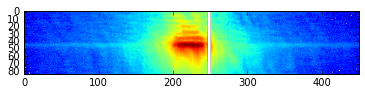

In [12]:
%matplotlib inline
plt.imshow(np.log10(iobs[12,:].sum(axis=(-1))))
#plt.imshow(np.log10(iobs.sum(axis=(0,-2))))

In [ ]:
# Experiment parameters
pixel_size_detector = 55e-6
psi_step = phistep
print("Cropped angular range: %6.3f, step=%6.4f"%(np.rad2deg(psi_step)*npsi, np.rad2deg(psi_step)))

In [ ]:
## Ptycho data

# Use only one stack - if memory allows it !
default_processing_unit.cl_stack_size = npos

# detector parameters
nu = vs[scan0]['nu']
detector = {'geometry': 'psic', 'delta': vs[scan0]['del'], 'nu': nu, 'pixel_size': pixel_size_detector,
            'distance': detector_distance, 'rotation_axis': 'phi', 'rotation_step': psi_step}
zs, ys, xs = zp[vpos] * 1e-6, yp[vpos] * 1e-6, xp[vpos] * 1e-6

xs *= np.cos(vphi.mean())  # !! pix piezo is rotated with phi (we don't care about movement along z)

print('del= %5.2f nu =%5.2f phi_step=%6.4f'%(np.rad2deg(detector['delta']),np.rad2deg(detector['nu']),np.rad2deg(detector['rotation_step'])))
# Create empty data
data = BraggPtychoData(iobs=iobs, positions=(zs, -ys, -xs), mask=None, wavelength=wavelength, detector=detector)

In [ ]:
# Import existing probe from 2D ptycho - only the first mode will be used
d = np.load("ResultsScan0014/latest.npz") # Siemens star
#d = np.load("ResultsScan0096/latest.npz")  # use the bragg ptycho scan
dpr = np.fft.fftshift(d['probe'],axes=(-2,-1))  # just flip the x,y axes - not the modes
#
pr = Wavefront(d=dpr, z=0, pixel_size=d['pixelsize'], wavelength=wavelength)
%matplotlib inline
pr = ImshowRGBA() * PropagateNearField(0e-6) * pr

In [ ]:
# Create main Bragg Ptycho object
p = BraggPtycho(probe=pr, data=data, support=None)
pxyz = p.voxel_size_object()
print("Object voxel size: %6.2fnm x %6.2fnm x %6.2fnm" % (pxyz[0] * 1e9, pxyz[1] * 1e9, pxyz[2] * 1e9))

In [ ]:
%matplotlib inline
# Create starting nanowire
x, y, z = p.get_xyz(domain='object', rotation=('y', nu / 2))
obj0 = (abs(y) < 800e-9) * (np.sqrt(x ** 2 + z ** 2) < 350e-9)
obj0 = obj0 * np.random.uniform(0,1,obj0.shape)
p.set_obj(obj0)

p = ShowObj() * p

# Set a support larger than the object
sup = (abs(y) < 1000e-9) * (np.sqrt(x ** 2 + z ** 2) < 400e-9)
p.set_support(sup)

In [ ]:
%matplotlib notebook
p = DM(calc_llk=10, show_obj_probe=20) ** 200 * p

In [ ]:
p = AP(calc_llk=10, show_obj_probe=10) ** 40 * p
p = ML(calc_llk=10, show_obj_probe=10) ** 40 * p

In [ ]:
p=FreePU()*p
#p=ShowObj()*AP()**40*p

In [ ]:
print("cos(<phi>=%6.2f)=%6.4f"%(np.rad2deg(vphi.mean()), np.cos(vphi.mean())))